# Višeručni bandit
Konceptualno **jednoruki bandit** je *slot mašina*.
Svaki slot je opisan uređenim parom (*m*, *s*) gde je **m** srednja vrednost dobitaka na mašini, dok je **s** standardna devijacija.

Postavka problema je takva da imamo beskonačno para i igramo **n** slotova koji nam po nekom pravilu vraća određene sume novaca. **Cilj** je maksimizovati u realnoj situaciji, tj. igrati slotove po nekom pravilu, a da ne znamo (*m*,*s*) ni za jednu.

**Faze** u našem algoritmu:

1.   *Test* faza - *Eksloracija*:

*   Biramo mašine i povlačimo poteze

*   Računamo *m*


2.   *Igranje najbolje mašine* - *Eksploatacija*

Biramo mašine pomoću **politike** odlučivanja:

1.   **Greedy** - bira se mašina sa najboljim **m** sa verovatnoćom 1
2.   **Ɛ-greedy** - bira se mašina sa najboljim **m** verovatnoćom Ɛ, a sa verovatnoćom 1-Ɛ se bira random mašina
3.   **Softmax**

Kako računati srednju vrednost mašine?
Pretpostavimo da je **q** trenutna srednja vrednost mašine. Definišemo:$$q^+ = p \cdot q + (1-p) \cdot q$$

Kada dodatno uvedemo smenu:$$\alpha = 1 - p$$
tako da konačna jednačina postaje:
$$q^+ =  q +α (1-q)$$

Ova estimacija se korsti da ne bi pamtili broj iteracija, tj. žrtvujemo izuzetno mali procenat tačnosti zarad boljeg memorijskog zauzeća.

Idealno bi bilo da je naše *q* jednako *m*, ali pošto se radi o konačnom broju iteracija želimo samo da *q* teži *m* na određeni broj decimala, srazmerno broju iteracija.


# Osnovne biblioteke

In [ ]:
from typing import Iterable
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

# Klasa Bandit

In [ ]:
class Bandit:
    def __init__(self, mean: float, span: float):
        self.mean = mean
        self.span = span

    # npr. srednja vrednost 1, 2*devijacija(npr. 5)*[-0.5,.0.5] ----> 1+-5
    def pull_leaver(self) -> float:
        return self.mean + self.span * 2 * (random.random() - 0.5)

# Testiranje jednog Bandita

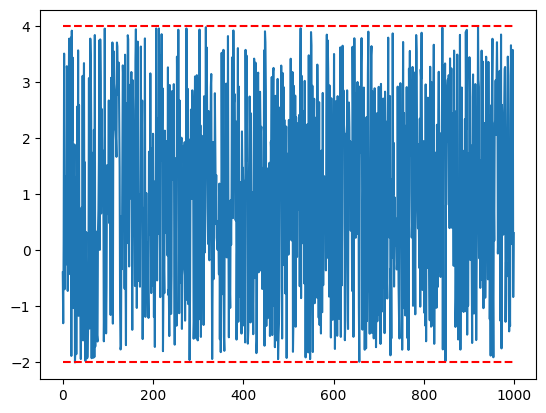

In [ ]:
test_mean = 1.0
test_span = 3.0
test_len = 1000
test_bandit = Bandit(test_mean, test_span)
test_rewards = [test_bandit.pull_leaver() for _ in range(test_len)]
plt.plot(test_rewards, label="rewards")
plt.plot((test_mean + test_span) * np.ones(test_len), linestyle="--", color="r")  # ---> crvena linija gornja
plt.plot((test_mean - test_span) * np.ones(test_len), linestyle="--", color="r")  # ---> crvena linija donja granica
plt.show()

# Okruženje = više Bandita


In [ ]:
class BanditsEnvironment:

    def __init__(self, bandits: Iterable[Bandit], penalty=1000):
        self.bandits: list[Bandit] = list(bandits)
        self.penalty = penalty

    def take_action(self, a: int):
        if a < 0 or a >= len(self.bandits):
            return -self.penalty
        else:
            return self.bandits[a].pull_leaver()

    def give_mean(self, a: int):
        return self.bandits[a].mean

    def give_span(self, a: int):
        return self.bandits[a].span

# Testiranje okruženja

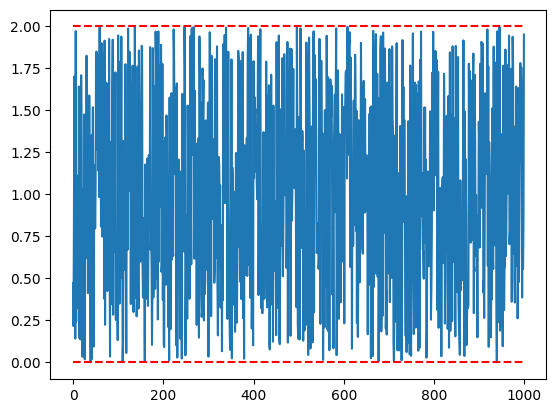

In [ ]:
test_env_size = 5
test_bandits = [Bandit(i ** 2, i) for i in
                range(test_env_size)]  # napravi se 5 bandita kojima su parametri redom (1,1) (4,2) (9,3) ...
test_env = BanditsEnvironment(
    test_bandits)  # koristi se nova klasa okruzenje za koje je neophodno bilo napraviti ovu listu bandita
selected_bandit = 1
test_rewards2 = [test_env.take_action(selected_bandit) for _ in range(
    test_len)]  # simuliramo nagrade za selektovanog bandita tako sto radi akciju, koja posto je on u opsegu vuce
# rucku samo, tj. nema kazne
plt.plot(test_rewards2, label="rewards")  # vidimo random raspodelu od 9+-3
plt.plot((selected_bandit ** 2 + selected_bandit) * np.ones(test_len), linestyle="--", color="r")  # na 12
plt.plot((selected_bandit ** 2 - selected_bandit) * np.ones(test_len), linestyle="--", color="r")  # na 6
plt.show()

# Odabir nepostojećeg Bandita

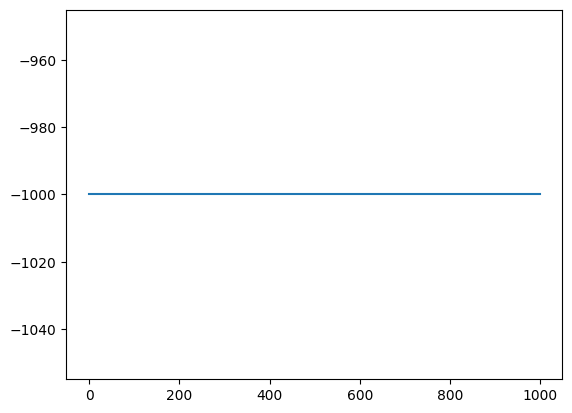

In [ ]:
selected_bandit = -1
test_rewards3 = [test_env.take_action(selected_bandit) for _ in range(test_len)]
plt.plot(test_rewards3, label="rewards")
plt.show()

# Ispis srednje vrednosti za random Bandita

Kako je srednja vrednost svakog bandita njegov kvadriran indeks za $i$-tog bandita njegova ocekivana srednja vrednost je $i^2$.

In [ ]:
ri = random.randint(0, 4)
test_rewards4 = [test_env.take_action(ri) for _ in range(test_len)]
test_mean = sum(test_rewards4) / test_len
print("TEST MEAN = ", test_mean, " for Bandt No.", ri)

TEST MEAN =  1.0082598686593138  for Bandt No. 1


# Politike odlučivanja



*   **Greedy**



In [ ]:
def choose_greedy_action(q):
    return np.argmax(q)

Test *greedy* politike, vraca indeks

4


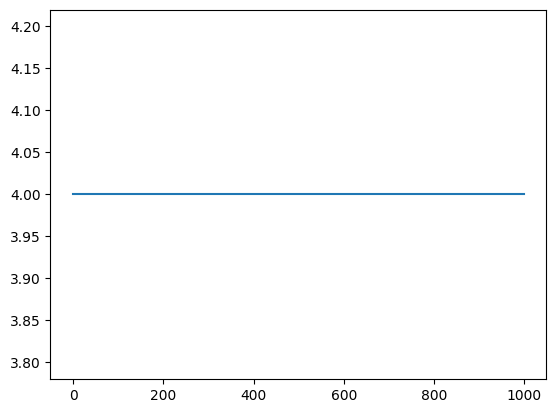

In [ ]:
test_q = [1, 2, 3, 2, 12]
print(choose_greedy_action(test_q))
test_actions = [choose_greedy_action(test_q) for _ in range(test_len)]
plt.plot(test_actions)
plt.show()

*    **Ɛ-greedy**

In [ ]:
def choose_random_action(n):
    return random.randint(0, n - 1)


def choose_eps_greedy_action(q, eps):
    if random.random() > eps:
        return choose_greedy_action(q)
    else:
        return choose_random_action(len(q))

Test *Ɛ-greedy* politike

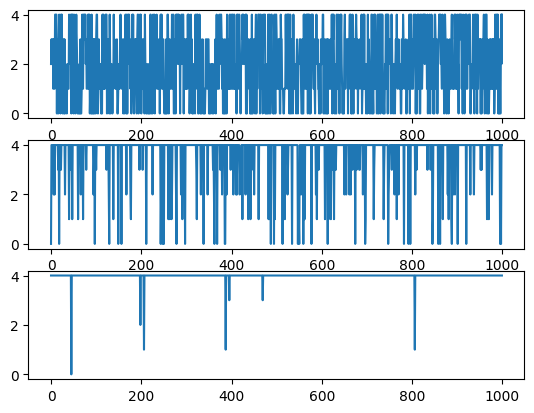

In [ ]:

plt.subplot(3, 1, 1)
plt.plot([choose_eps_greedy_action(test_q, 1.0) for _ in range(test_len)])  # uvek ce birati random
plt.subplot(3, 1, 2)
plt.plot([choose_eps_greedy_action(test_q, 0.2) for _ in range(test_len)])  # u 20% slucajeva ce biti random
plt.subplot(3, 1, 3)
plt.plot([choose_eps_greedy_action(test_q, 0.01) for _ in range(test_len)])  # u 1% slucajeva ce biti random
plt.show()


# Treniranje Bandita

Definisanje konstanti

In [ ]:
BANDITS_NO = 5
ATTEMPTS_NO = 6500
ALPHA = 0.1
EPSILON1 = 0.1
EPSILON2 = 0.01

Umesto da menjamo karakteristike bandita, kreiraćemo novo okruženje i nove bandite zbog potnecijalnog korišćenja starih karakteristika bandita.

In [ ]:
bandits1 = [Bandit(10 * (random.random() - 0.5), 5 * random.random()) for _ in range(BANDITS_NO)]
# znaci imacemo Badndit(10*[-0.5,0.5], 5*[0,1])
bandits2 = [Bandit(10 * (random.random() - 0.5), 5 * random.random()) for _ in range(BANDITS_NO)]
env1 = BanditsEnvironment(bandits1)
env2 = BanditsEnvironment(bandits2)

Da vidimo kako izgledaju Banditi:

In [ ]:
def ispis_bandita():
    for i in range(BANDITS_NO):
        print("In Environment 1 Bandit No.", i, "is defined with:(", bandits1[i].mean, ",", bandits1[i].span, ") \n")


ispis_bandita()

In Environment 1 Bandit No. 0 is defined with:( -0.11961143453545375 , 0.2727618057422998 ) 

In Environment 1 Bandit No. 1 is defined with:( 3.830648646288669 , 0.5355504590283439 ) 

In Environment 1 Bandit No. 2 is defined with:( 3.0815848529002663 , 3.5814642172673814 ) 

In Environment 1 Bandit No. 3 is defined with:( 1.7025687209302864 , 1.3808193005477487 ) 

In Environment 1 Bandit No. 4 is defined with:( -0.7160530900027506 , 2.7146648590462448 ) 



Inicijalizovanje dodatnih promnjivih pre početka treniranja:

In [ ]:
q1 = [100 for _ in range(BANDITS_NO)]  # [100,100,100,100,100] sto su pocetne srednje vrednosti za igru
q2 = [100 for _ in range(BANDITS_NO)]
# totalno nebitne jer u formuli imamo r-q[a] tako da ce formula brzo konverigrati ka svom realnom q. Ove promenljive na pocetku agent misli da vaze za masine
# npr. prva iteracija alpha(4-100)
# print(q)
rewards1 = []
rewards2 = []
rez1 = [[], [], [], [], []]

# 3. Zadatak
Vrednosti Bandita se menjaju tokom vremena. Posle iteracije 4000 se menjaju Banditi tako što koristimo nove Bandite iz novog okruženja.

In [ ]:
#dodatno je ovde jer se koristi funkcija append pa ako pokrecemo ovu celiju vise puta moze doci do greske
for t in trange(ATTEMPTS_NO):  # samo za progres bar nista posebno
    if t < 4000:
        a1 = choose_eps_greedy_action(q1, EPSILON1)  # 10% sanse da uzme najjacu masinu 90% da uzme random ---> vraca redni
    # broj masine/bandita koju/kog bira
        r1 = env1.take_action(a1)  # govori nam kolka je zarada a1-tog bandita
        q1[a1] = q1[a1] + ALPHA * (r1 - q1[a1])  # formula za novu srednju vrednost a1-tog bandita
        rez1[a1].append(q1[a1])
        rewards1.append(r1)  # cuvamo vrednosti nagrada prvih 5 bandita
    else:
        a2 = choose_eps_greedy_action(q2, EPSILON2)
        r2 = env2.take_action(a2)  # govori nam kolka je zarada a2-tog bandita
        q2[a2] = q2[a2] + ALPHA * (r2 - q2[a2])  # formula za novu srednju vrednost a2-tog bandita
        rewards2.append(r2)  # cuvamo vrednosti nagrada drugih 5 bandita

100%|██████████| 6500/6500 [00:00<00:00, 145333.55it/s]


# Realne i dobijene srednje vrednosti za Bandite iz prvog okruženja

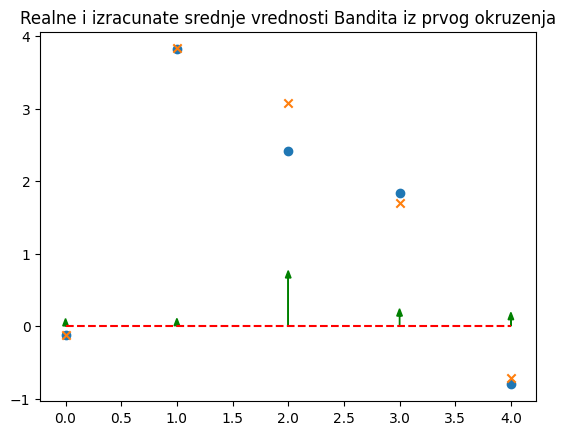

In [ ]:
plt.title("Realne i izracunate srednje vrednosti Bandita iz prvog okruzenja")
plt.scatter(range(len(q1)), q1, marker="o")
plt.scatter(range(len(q1)), [b.mean for b in env1.bandits], marker="x")
diff = [0, 0, 0, 0, 0]
for i in range(len(q1)):
    diff[i] = np.abs(q1[i] - env1.give_mean(i))
for i in range(len(q1)):
  plt.arrow(i, 0, 0, diff[i], head_width=0.05, head_length=0.1, fc="green", ec="green")
plt.plot(np.zeros(len(q1)), linestyle="--", color="r")
plt.show()


# Realne i dobijene srednje vrednosti za Bandite iz drugog okruženja

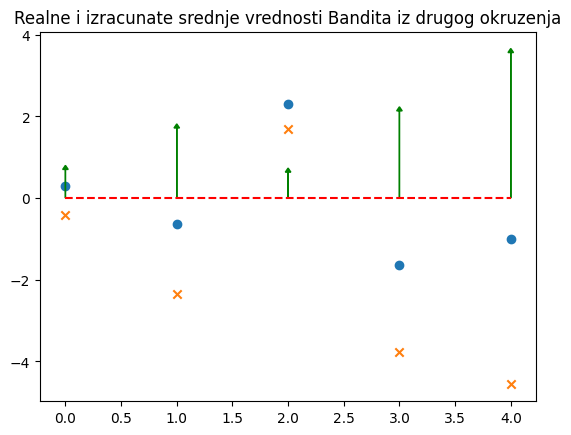

In [ ]:
plt.title("Realne i izracunate srednje vrednosti Bandita iz drugog okruzenja")
plt.scatter(range(len(q2)), q2, marker="o")
plt.scatter(range(len(q2)), [b.mean for b in env2.bandits], marker="x")
diff2 = [0, 0, 0, 0, 0]
for i in range(len(q2)):
    diff2[i] = np.abs(q2[i] - env2.give_mean(i))
for i in range(len(q2)):
  plt.arrow(i, 0, 0, diff2[i], head_width=0.05, head_length=0.1, fc="green", ec="green")
plt.plot(np.zeros(len(q2)), linestyle="--", color="r")
plt.show()

Možemo primetiti da vrednosti iz drugog okruženja manje teže svojim vrednostima. Imamo 2 razloga za to, stim da je jedan mnogo uticajniji, a to je da je ɛ u drugom okruženju 10 puta manje, tj. 0.01 što zanči da je šansa da se izabere random bandit 1% i kad na to dodamo da se drugi deo koda izvršava nešto manje od duplo manje iteracija dobijemo veliku grešku računanja za neke od Bandita.

# 4. Zadatak

Prikazaćemo kako svaki od Bandita iz prvog okruženja konvergira ka svojim vrednostima. Drugo okruženje ćemo preskočiti, jer nema smisla to prikazivati zbog nedovljno iteracija za onakvu politiku sa onakvim paramterom kakva je upotrebljena na tom okruženju.

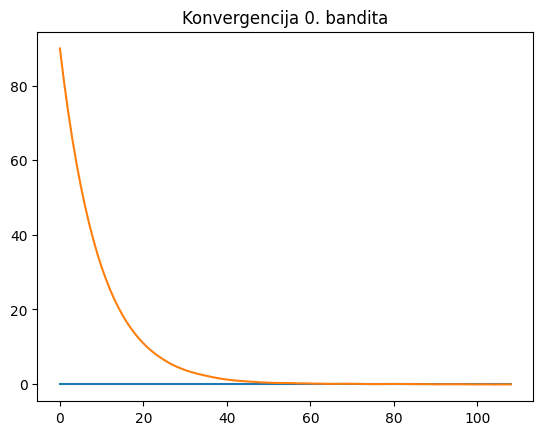

In [ ]:
m = [b.mean for b in env1.bandits]
plt.title("Konvergencija 0. bandita")
plt.plot(m[0] * np.ones(len(rez1[0])))
plt.plot(rez1[0])
plt.show()

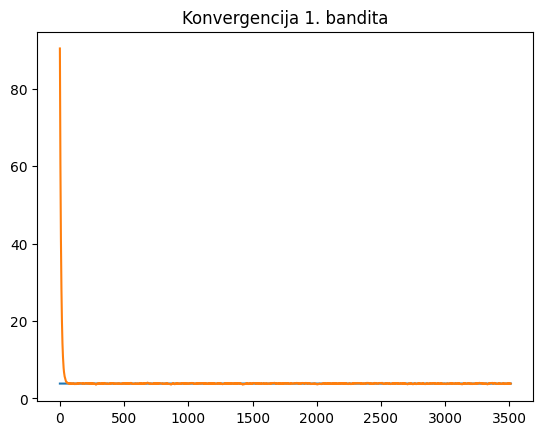

In [ ]:
plt.title("Konvergencija 1. bandita")
plt.plot(m[1] * np.ones(len(rez1[1])))
plt.plot(rez1[1])
plt.show()

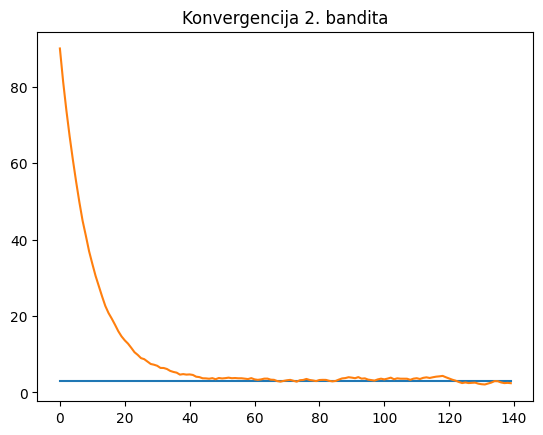

In [ ]:
plt.title("Konvergencija 2. bandita")
plt.plot(m[2] * np.ones(len(rez1[2])))
plt.plot(rez1[2])
plt.show()

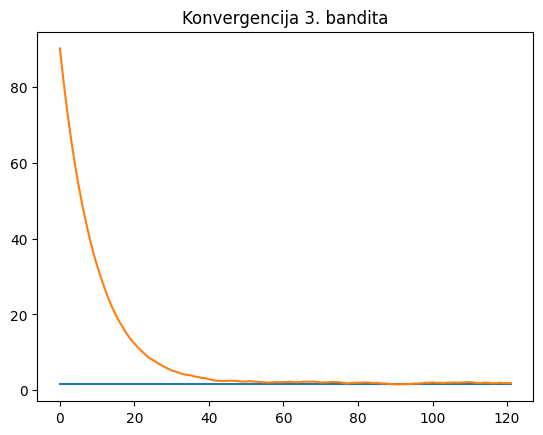

122


In [ ]:
plt.title("Konvergencija 3. bandita")
plt.plot(m[3] * np.ones(len(rez1[3])))
plt.plot(rez1[3])
plt.show()
print(len(rez1[3]))

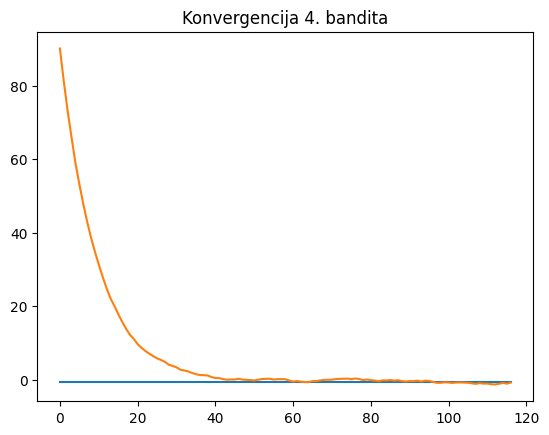

In [ ]:
plt.title("Konvergencija 4. bandita")
plt.plot(m[4] * np.ones(len(rez1[4])))
plt.plot(rez1[4])
plt.show()

Da vidimo kako je radila naša ε politka za prvo okruženje.

In [ ]:
max = 0
najboji = -1
for i in range(5):
  if len(rez1[i])>max:
    max = len(rez1[i])
    najbolji = i
print("Nasa politika je birala najbolji slot pod rednim brojem",najbolji,".sa sansom od",(1-EPSILON1)*100,"% i on je na 4000 iteracija izabran",max,"puta, dok su ostali birani",len(rez1[0])+len(rez1[1])+len(rez1[2])+len(rez1[3])+len(rez1[4])-max,"puta.")

Nasa politika je birala najbolji slot pod rednim brojem 1 .sa sansom od 90.0 % i on je na 4000 iteracija izabran 3512 puta, dok su ostali birani 488 puta.


# 1. Zadatak

Imamo dva epsilon tako da cemo plotovati dva grafika na kojem je totalni greedy algoritam, protiv politike sa koeficijentom ε1, pa posle toga isto to samo protiv politike sa koeficijentom ε2.

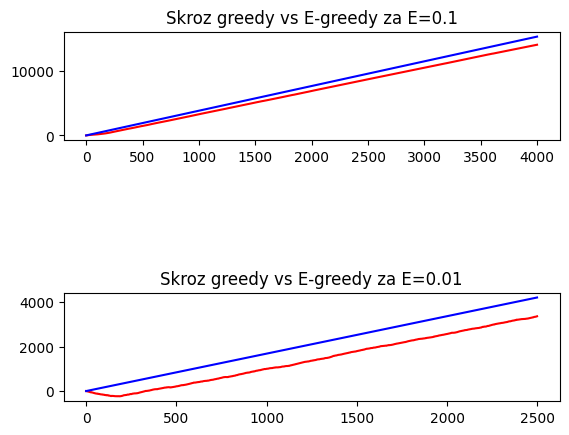

In [ ]:
g1 = np.cumsum(rewards1)
g2 = np.cumsum(rewards2)
m1= [b.mean for b in env1.bandits]
max_r1 = -np.inf
for i in range(len(m1)):
  if m1[i]>max_r1:
    max_r1 = m1[i]
m2= [b.mean for b in env2.bandits]
max_r2 = -np.inf
for i in range(len(m2)):
  if m2[i]>max_r2:
    max_r2 = m2[i]
plt.subplot(3, 1, 1)
plt.title("Skroz greedy vs E-greedy za E=0.1")
plt.plot(g1, color="r")
plt.plot(np.cumsum(max_r1 * np.ones(len(g1))), color="b")
# 1.Probati sa manjim epsilon, da se vidi da je manja razlika nagiba
plt.subplot(3, 1, 3)
plt.title("Skroz greedy vs E-greedy za E=0.01")
plt.plot(g2, color="r")
plt.plot(np.cumsum(max_r2 * np.ones(len(g2))), color="b")
plt.show()

# 2.Zadatak

Uzećemo naučeno $q$ i probaćemo još određeni broj iteracija sa 0% šanse da se izabere random mašina, tj. koristićemo potupno greedy algoritam.

100%|██████████| 2000/2000 [00:00<00:00, 101333.72it/s]


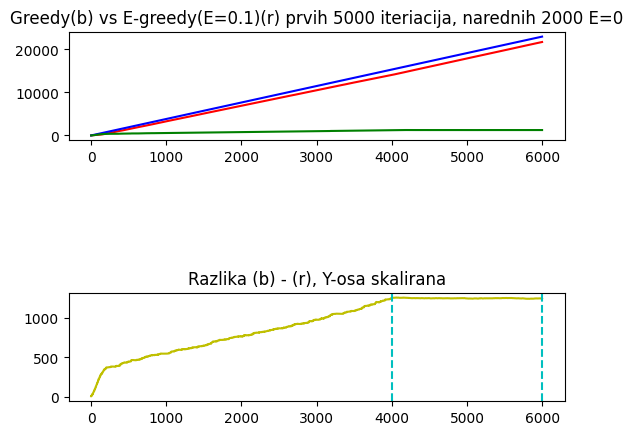

In [ ]:
for t in trange(2000):
    a = choose_eps_greedy_action(q1, 0)
    # broj masine/bandita koju/kog bira
    r = env1.take_action(a)  # govori nam kolka je zarada a-tog bandita
    g1[a] = g1[a] + ALPHA * (r - q1[a])  # formula za novu srednju vrednost a-te masine
    # print(q[1])
    # just for logging
    rewards1.append(r)  # cuvamo vrednosti nagrada
g = np.cumsum(rewards1)
# ne mora se novo maxr raditi
plt.subplot(3, 1, 1)
plt.title("Greedy(b) vs E-greedy(E=0.1)(r) prvih 5000 iteriacija, narednih 2000 E=0")
plt.plot(g, color="r")
plt.plot(np.cumsum(max_r1 * np.ones(len(g))), color="b")
diff2 = np.zeros(len(g))
for i in range(len(g)):
    diff2[i] = np.cumsum(max_r1 * np.ones(len(g)))[i] - g[i]
plt.plot(diff2, color="g")
plt.subplot(3, 1, 3)
plt.title("Razlika (b) - (r), Y-osa skalirana")
plt.plot(diff2, color="y")
plt.axvline(4000, color="c", linestyle="--")
plt.axvline(6000, color="c", linestyle="--")
plt.show()